In [44]:
# GNN and Tabular Transformer (Address-level)
# Single-file notebook-style script using cell separators (for Jupyter/VSCode: Run cells)
# This version is tailored for the provided file: /mnt/data/ethereum_raw.csv
# It assumes the file is already address-level with columns: 'Address' (ID) and 'FLAG' (label).
# The notebook will: load data, preprocess, build a KNN similarity graph for GNN, train a node-classifier GNN and a Tabular Transformer, evaluate and save artifacts.


In [45]:
# 1) Setup & imports

# Standard library imports
import os                     # filesystem operations (paths, mkdir)
import random                 # pseudo-random utilities (seed, random)
import pickle                 # serialization for saving/loading Python objects

# Data science / numeric libraries
import numpy as np            # numerical arrays and operations
import pandas as pd           # tabular data handling (DataFrame)

# PyTorch (deep learning)
import torch                  # core PyTorch (tensors, device handling, random seeds)
import torch.nn as nn         # neural network building blocks (modules, layers)
import torch.nn.functional as F  # functional forms of common layers / losses

# Scikit-learn utilities for preprocessing, splitting and evaluation
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,                  # AUC-ROC metric
    precision_recall_curve,        # precision-recall curve helper
    auc,                           # area under curve helper (used for PR AUC)
    precision_recall_fscore_support,# detailed precision/recall/fscore per class
    accuracy_score                 # simple accuracy metric
)
from sklearn.neighbors import NearestNeighbors  # for computing nearest neighbors (graph construction / overlap checks)

# Optional: PyTorch Geometric (graph neural network utilities)
# Wrapped in try/except because not all environments have torch_geometric installed.
try:
    import torch_geometric
    from torch_geometric.data import Data   # container for graph data (node features, edge index, labels)
    from torch_geometric.nn import SAGEConv # GraphSAGE convolution layer (used for GNN)
except Exception as e:
    # If import fails, print a clear message but allow the notebook to continue (we might only run baselines).
    print("torch_geometric not installed or import failed:", e)

# Optional: LightGBM for baseline gradient-boosted trees
# Wrapped in try/except so notebook still runs even if lightgbm is missing.
try:
    import lightgbm as lgb
except Exception:
    lgb = None  # mark as unavailable — downstream code should check this before using LightGBM

# Reproducibility: fix random seeds for Python, NumPy and PyTorch
SEED = 42
random.seed(SEED)        # seed Python's random
np.random.seed(SEED)     # seed NumPy's RNG
# If CUDA is available, also set CUDA seeds and deterministic flags to reduce nondeterminism
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # Force deterministic convolution algorithms (may slow training but improves reproducibility)
    torch.backends.cudnn.deterministic = True
    # Disable benchmark to prevent nondeterministic algorithm selection
    torch.backends.cudnn.benchmark = False

# Paths and artifacts
DATA_PATH = 'E:/Projects/CBK_Assignment/Greenland_Registry/ethereum_raw.csv'  # raw CSV dataset path
ARTIFACTS_DIR = './artifacts'  # directory to store outputs (models, processed data, logs)
os.makedirs(ARTIFACTS_DIR, exist_ok=True)  # create artifacts directory if it doesn't exist


In [46]:
# 2) Load CSV & quick EDA (Exploratory Data Analysis)

# Print which file is being loaded for clarity
print('Loading', DATA_PATH)

# Load the Ethereum dataset from the specified CSV file path into a pandas DataFrame
df = pd.read_csv(DATA_PATH)

# Display the number of rows (samples) and columns (features) to understand dataset size
print('Rows, cols:', df.shape)

# Print the list of all column names to get an overview of available features
print(df.columns.tolist())

# Show the first 3 rows of the dataset to visually inspect structure, datatypes, and example values
print(df.head(3))


Loading E:/Projects/CBK_Assignment/Greenland_Registry/ethereum_raw.csv
Rows, cols: (9841, 51)
['Unnamed: 0', 'Index', 'Address', 'FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr', ' ERC20 avg time between sent tnx', ' ERC20 avg time between 

In [47]:
# 3) Remove leaking or redundant index-like columns

# Some CSV exports (especially from pandas) include an extra "Unnamed: 0" or "Index" column 
# that simply duplicates the row index — this can leak information during model training.
# The following code checks for such columns and drops them if they exist.

if 'Unnamed: 0' or 'Index' in df.columns:
    # Drop both columns if present; errors='ignore' ensures no error is raised if not found
    df = df.drop(columns=['Unnamed: 0', 'Index'], errors='ignore')

# Display the first 5 rows again to confirm that unwanted columns are removed
df.head(5)


,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [48]:
# 4) Train/validation/test split + preprocessing (fit transformers on TRAIN only)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pickle, numpy as np, os

# Assumptions: df is already loaded, contains columns 'Address' and 'FLAG'
# If your notebook had explicit lists for numeric/categorical columns, reuse them.
# Otherwise auto-detect:
# Build feature list by excluding identifier/target-like columns
feature_cols = [c for c in df.columns if c not in ('Address', 'FLAG', 'flag', 'Label', 'label')]
addresses = df['Address'].values               # keep original addresses (for later mapping / graph construction)
y = df['FLAG'].values                           # target labels array

# crude split of categorical vs numeric (you can override lists if you had custom lists)
# Treat columns as categorical if dtype==object OR they have low cardinality (<50 unique values)
categorical_cols = [c for c in feature_cols if df[c].dtype == 'object' or df[c].nunique() < 50]
numeric_cols = [c for c in feature_cols if c not in categorical_cols]  # remaining considered numeric

# INDEX-BASED SPLIT (stratified to preserve class balance)
idx = np.arange(len(df))  # array of row indices
# Hold out 20% for final test set, stratifying by the label y to keep class proportions
train_idx, test_idx = train_test_split(idx, test_size=0.20, random_state=SEED, stratify=y)
# From the remaining training indices, split a validation set (15% of the original train indices)
train_idx, val_idx  = train_test_split(train_idx, test_size=0.15, random_state=SEED, stratify=y[train_idx])
print(f"Split sizes: train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")

# Prepare raw column-wise DataFrames for convenience (we will transform these)
X_raw_num = df[numeric_cols].copy()   # numeric features (may contain NaNs)
X_raw_cat = df[categorical_cols].copy()# categorical features (strings / low-cardinality values)

# --- Fit transformers ON TRAIN ONLY --- (important: avoid leakage from validation/test)
# 1) LabelEncoders for categorical columns
cat_encoders = {}  # will store fitted label encoders + mapping + unknown index per column
# Preallocate an integer array to hold encoded categorical values for all rows
X_cat = np.empty((len(df), len(categorical_cols)), dtype=np.int32)
for i, col in enumerate(categorical_cols):
    le = LabelEncoder()
    # Replace missing values with a sentinel token and convert to string before fitting
    train_vals = X_raw_cat.iloc[train_idx][col].fillna("<<NA>>").astype(str)
    le.fit(train_vals)  # fit only on training values to avoid leakage
    # Create a mapping from observed category value -> integer index
    mapping = {v: idx_ for idx_, v in enumerate(le.classes_)}
    unk_index = len(mapping)  # reserve a new index for unseen categories in val/test
    # Apply mapping to all rows safely: map known values, unseen values -> unk_index
    X_cat[:, i] = X_raw_cat[col].fillna("<<NA>>").astype(str).map(lambda x: mapping.get(x, unk_index)).values
    # Save encoder info so we can inverse-transform or reuse later
    cat_encoders[col] = {"label_encoder": le, "mapping": mapping, "unk_index": unk_index}

# 2) StandardScaler for numeric columns (fit on train numeric only)
scaler = StandardScaler()
# Fill NaNs with 0 for fitting (simple imputation). Important: fit on train rows only.
scaler.fit(X_raw_num.iloc[train_idx].fillna(0).values)

# transform numeric features for all rows using the fitted scaler (same imputation strategy)
X_num_scaled = scaler.transform(X_raw_num.fillna(0).values)

# --- Build final X arrays (concatenate numeric + encoded categorical) ---
# Cast categorical encodings to float and hstack with scaled numeric features for model compatibility
X_all = np.hstack([X_num_scaled, X_cat.astype(float)])   # final feature matrix (rows x features)

# split into train/val/test arrays using previously computed indices
X_train = X_all[train_idx]
X_val   = X_all[val_idx]
X_test  = X_all[test_idx]

y_train = y[train_idx]
y_val   = y[val_idx]
y_test  = y[test_idx]

# Also split addresses so we can map back predictions to original entities later
addresses_train = addresses[train_idx]
addresses_val   = addresses[val_idx]
addresses_test  = addresses[test_idx]

# drop = ['suspect_col1','suspect_col2']
# X_train = X_train.drop(columns=drop).values  # adapt to your code if you need to remove columns after building X

print("Feature count:", X_all.shape[1])

# Save artifacts (scalers/encoders + splits) so downstream cells use train-fitted objects
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
with open(os.path.join(ARTIFACTS_DIR, "preproc_train_encoders.pkl"), "wb") as f:
    # Persist column lists, encoders, and the scaler so later cells (or other runs) can load and reproduce transforms
    pickle.dump({"categorical_cols": categorical_cols,
                 "numeric_cols": numeric_cols,
                 "cat_encoders": cat_encoders,
                 "scaler": scaler,
                 "feature_cols": feature_cols}, f)

# Save numpy splits used by later cells for quick loading (avoids re-running preprocessing)
np.save(os.path.join(ARTIFACTS_DIR, "X_train.npy"), X_train)
np.save(os.path.join(ARTIFACTS_DIR, "X_val.npy"), X_val)
np.save(os.path.join(ARTIFACTS_DIR, "X_test.npy"), X_test)
np.save(os.path.join(ARTIFACTS_DIR, "y_train.npy"), y_train)
np.save(os.path.join(ARTIFACTS_DIR, "y_val.npy"), y_val)
np.save(os.path.join(ARTIFACTS_DIR, "y_test.npy"), y_test)
np.save(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), addresses_train)
np.save(os.path.join(ARTIFACTS_DIR, "addresses_val.npy"), addresses_val)
np.save(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), addresses_test)

print("Saved train-only preproc artifacts to", ARTIFACTS_DIR)
# ----- END REPLACEMENT BLOCK -----


Split sizes: train=6691, val=1181, test=1969
Feature count: 47
Saved train-only preproc artifacts to ./artifacts


In [49]:
# ---- Evaluate LightGBM with same metrics & print in same format as GNN output ----

import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score, precision_recall_curve, auc

# Ensure test arrays are available in the notebook; if not, load from artifacts saved earlier
import os
ARTIFACTS_DIR = './artifacts'
if 'X_test' not in globals():
    # load pre-saved numpy arrays for test features and labels
    X_test = np.load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))
    y_test = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))

# ---- Load trained LightGBM model if not already in memory ----
import os, joblib
ARTIFACTS_DIR = './artifacts'

if 'best_lgb' not in globals():
    # load the persisted LightGBM model object (joblib file) from artifacts
    best_lgb = joblib.load(os.path.join(ARTIFACTS_DIR, "lgb_best.pkl"))
    print("✅ Loaded best_lgb from saved file.")

# Predict probabilities and class labels on the test set
probs = best_lgb.predict_proba(X_test)[:,1]   # probability of the positive class
preds = (probs > 0.5).astype(int)             # threshold at 0.5 to get binary predictions

# Compute evaluation metrics consistent with GNN reporting
auc_score = roc_auc_score(y_test, probs)      # ROC AUC using probabilities
prec, rec, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary', zero_division=0)
acc = accuracy_score(y_test, preds)           # simple accuracy

# Print a single-line summary matching GNN output formatting for easy comparison
print(f"LightGBM TEST auc: {auc_score:.6f} prec: {prec:.6f} rec: {rec:.6f} f1: {f1:.6f} acc: {acc:.6f}")

# Also compute and print Precision-Recall AUC (PR-AUC)
pr, rc, _ = precision_recall_curve(y_test, probs)  # precision, recall curve points
pr_auc = auc(rc, pr)                                # area under PR curve
print(f"LightGBM PR-AUC: {pr_auc:.6f}")

# Save probabilities, predicted labels and true labels for downstream visualization / comparison
np.save(os.path.join(ARTIFACTS_DIR, "lgb_test_probs.npy"), probs)
np.save(os.path.join(ARTIFACTS_DIR, "lgb_test_preds.npy"), preds)
np.save(os.path.join(ARTIFACTS_DIR, "lgb_test_true.npy"), y_test)


LightGBM TEST auc: 0.999527 prec: 0.995294 rec: 0.970183 f1: 0.982578 acc: 0.992382
LightGBM PR-AUC: 0.998561


e:\Projects\CBK_Assignment\Greenland_Registry\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [50]:
# 4) Build KNN graph from feature similarity (for GNN node classification)

# We'll build an undirected kNN graph where each node connects to its k nearest neighbours
K = 10
print('Building kNN graph with k=', K)

# ---- INSERT THIS (reconstruct X/y/addresses and split indices) ----
import numpy as np, os
ARTIFACTS_DIR = './artifacts'

# If the full feature matrix X is not already in memory, load the saved train/val/test splits
# and reconstruct a single concatenated X (so node indices are continuous: train->val->test).
# This ensures graph node ids match downstream GNN indexing expectations.
# ---- PATCH: load splits (use allow_pickle=True for object/string arrays) ----
if 'X' not in globals():
    # load numeric feature splits saved earlier
    X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
    X_val   = np.load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
    X_test  = np.load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))
    # load label splits
    y_train = np.load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
    y_val   = np.load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
    y_test  = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))
    # addresses were saved as object/string arrays -> use allow_pickle=True to load safely
    a_tr = np.load(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), allow_pickle=True)
    a_va = np.load(os.path.join(ARTIFACTS_DIR, "addresses_val.npy"), allow_pickle=True)
    a_te = np.load(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), allow_pickle=True)
# ---- end patch ----


    # Recreate a single X/y/addresses variable by concatenating train -> val -> test.
    # This gives a coherent node indexing for the KNN graph (nodes 0..n_train-1 = train, etc.).
    X = np.vstack([X_train, X_val, X_test])
    y = np.concatenate([y_train, y_val, y_test])
    addresses = np.concatenate([a_tr, a_va, a_te])

    # create split indices (downstream code that expects train_idx/val_idx/test_idx will work)
    n_train = X_train.shape[0]
    n_val   = X_val.shape[0]
    n_test  = X_test.shape[0]
    train_idx = np.arange(0, n_train)
    val_idx   = np.arange(n_train, n_train + n_val)
    test_idx  = np.arange(n_train + n_val, n_train + n_val + n_test)

    # quick sanity print to confirm shapes and split sizes
    print("Reconstructed X shape:", X.shape, "  splits:", n_train, n_val, n_test)
# ---- end insertion ----

# Fit a k-nearest-neighbors index on the full feature matrix X.
# Use cosine distance and n_neighbors = K+1 because the closest neighbor of a point is itself.
knn = NearestNeighbors(n_neighbors=min(K+1, X.shape[0]), metric='cosine', n_jobs=-1).fit(X)
dists, neigh = knn.kneighbors(X, return_distance=True)  # dists: distances, neigh: neighbor indices

# build edge list from neighbor indices
rows = []
cols = []
N = X.shape[0]  # total number of nodes

for i in range(N):
    # neighbors array includes self as first column; skip index 0 to avoid self-loops
    # also guard against cases where fewer neighbors are available
    neighbors = neigh[i, 1: min(K+1, neigh.shape[1])]
    for j in neighbors:
        rows.append(i)          # source node
        cols.append(int(j))     # target node (cast to int for torch)

# Make the graph undirected by adding reverse edges (rows+cols, cols+rows)
edge_index = torch.tensor([rows + cols, cols + rows], dtype=torch.long)

# Convert node feature matrix and labels to torch tensors for PyG compatibility
x_nodes = torch.tensor(X, dtype=torch.float)   # node feature matrix
y_nodes = torch.tensor(y, dtype=torch.long)    # node labels (integers)

# Save graph artifacts (edge index, node features, labels, and addresses) for reuse by GNN training/eval
torch.save({'edge_index': edge_index, 'x': x_nodes, 'y': y_nodes, 'addresses': addresses}, os.path.join(ARTIFACTS_DIR, 'graph_artifacts.pt'))
print('Saved graph artifacts. Nodes:', N, 'Edges:', edge_index.shape[1])


Building kNN graph with k= 10
Saved graph artifacts. Nodes: 9841 Edges: 196820


In [51]:
# 6) GNN (node classification) training & evaluation using GraphSAGE

# Select device: GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Load previously saved graph artifacts (edge_index, node features x, labels y, addresses)
art = torch.load(os.path.join(ARTIFACTS_DIR, 'graph_artifacts.pt'))
edge_index = art['edge_index'].to(device)   # edge index tensor for PyG-style graph (2 x num_edges)
x_nodes = art['x'].to(device)               # node feature matrix (N x F)
y_nodes = art['y'].to(device)               # node labels (N,)

# Create a simple stratified node split for training/validation/testing.
# This ensures class proportions are similar across splits.
idx = np.arange(x_nodes.shape[0])  # node indices 0..N-1
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=SEED, stratify=y_nodes.cpu().numpy())
train_idx, val_idx = train_test_split(train_idx, test_size=0.15, random_state=SEED, stratify=y_nodes.cpu().numpy()[train_idx])

# Define a small GraphSAGE-based GNN for node classification
class NodeGNN(nn.Module):
    def __init__(self, in_ch, hidden=128, num_layers=2):
        super().__init__()
        self.convs = nn.ModuleList()
        # first layer: input channels -> hidden
        self.convs.append(SAGEConv(in_ch, hidden))
        # additional SAGEConv layers (hidden -> hidden)
        for _ in range(num_layers-1):
            self.convs.append(SAGEConv(hidden, hidden))
        # final linear head producing a single logit per node (binary classification)
        self.head = nn.Linear(hidden, 1)  # single logit for binary

    def forward(self, x, edge_index):
        # apply each GraphSAGE conv followed by ReLU
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        # head returns a single value per node; squeeze to shape (N,)
        return self.head(x).squeeze(-1)

# Instantiate model and optimizer; move model to chosen device
model = NodeGNN(in_ch=x_nodes.shape[1], hidden=128, num_layers=2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Handle class imbalance by computing a pos_weight for BCEWithLogitsLoss:
# pos_weight = (#negatives) / (#positives). If no positives present, default to 1.0.
pos_weight = (y_nodes==0).sum().float() / (y_nodes==1).sum().float() if (y_nodes==1).sum()>0 else torch.tensor(1.0)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

# Training loop: 100 epochs, reporting validation metrics every 5 epochs
for epoch in range(1, 101):
    model.train()
    opt.zero_grad()
    logits = model(x_nodes, edge_index)  # forward pass -> raw logits for all nodes
    # compute loss only on training nodes (node classification)
    loss = loss_fn(logits[train_idx], y_nodes[train_idx].float())
    loss.backward()
    opt.step()

    # Periodic evaluation on validation set (every 5 epochs)
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            # NOTE: `logits` here are from the forward pass above (on current weights).
            # Apply sigmoid to get probabilities for the validated nodes.
            val_logits = torch.sigmoid(logits[val_idx]).cpu().numpy()
            val_pred = (val_logits > 0.5).astype(int)           # thresholded predictions
            val_true = y_nodes[val_idx].cpu().numpy().astype(int)
            try:
                auc_val = roc_auc_score(val_true, val_logits)   # ROC-AUC on validation
            except Exception:
                auc_val = float('nan')                         # handle degenerate cases
            prec, rec, f1, _ = precision_recall_fscore_support(val_true, val_pred, average='binary', zero_division=0)
        # Print compact training progress line (loss + validation metrics)
        print(f'Epoch {epoch} loss={loss.item():.4f} val_auc={auc_val:.4f} prec={prec:.4f} rec={rec:.4f} f1={f1:.4f}')

# After training, run full evaluation: compute probabilities/predictions on test nodes
model.eval()
with torch.no_grad():
    logits = model(x_nodes, edge_index)           # compute logits for all nodes with final weights
    probs = torch.sigmoid(logits).cpu().numpy().squeeze()  # probabilities for positive class
    test_probs = probs[test_idx]                  # probabilities restricted to test node indices
    test_pred = (test_probs > 0.5).astype(int)    # binary predictions with 0.5 threshold
    test_true = y_nodes[test_idx].cpu().numpy().astype(int)

# Save GNN test artifacts (probabilities, preds, true labels) for downstream comparison / visualization
np.save(os.path.join(ARTIFACTS_DIR, "gnn_test_probs.npy"), test_probs)
np.save(os.path.join(ARTIFACTS_DIR, "gnn_test_preds.npy"), test_pred)
np.save(os.path.join(ARTIFACTS_DIR, "gnn_test_true.npy"), test_true)
print("Saved GNN artifacts for comparison.")

# Compute final test metrics and print them
test_auc = roc_auc_score(test_true, test_probs) if len(np.unique(test_true))>1 else float('nan')
prec, rec, f1, _ = precision_recall_fscore_support(test_true, test_pred, average='binary', zero_division=0)
acc = accuracy_score(test_true, test_pred)
print('GNN TEST auc:', test_auc, 'prec:', prec, 'rec:', rec, 'f1:', f1, 'acc:', acc)


Device: cuda


C:\Users\manis\AppData\Local\Temp\ipykernel_19264\1052700803.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(os.path.join(ARTIFACTS_DIR, 'graph_artifact

Epoch 5 loss=1.3873 val_auc=0.4881 prec=0.2134 rec=0.3295 f1=0.2590
Epoch 10 loss=1.2634 val_auc=0.5014 prec=0.1667 rec=0.0230 f1=0.0404
Epoch 15 loss=1.1002 val_auc=0.5216 prec=0.2605 rec=0.1188 f1=0.1632
Epoch 20 loss=1.1647 val_auc=0.4973 prec=0.2156 rec=0.4559 f1=0.2927
Epoch 25 loss=1.0763 val_auc=0.5353 prec=0.2303 rec=0.4828 f1=0.3119
Epoch 30 loss=1.0973 val_auc=0.5057 prec=0.1875 rec=0.2069 f1=0.1967
Epoch 35 loss=1.0723 val_auc=0.5101 prec=0.2228 rec=0.6360 f1=0.3300
Epoch 40 loss=1.0768 val_auc=0.5150 prec=0.2233 rec=0.7778 f1=0.3470
Epoch 45 loss=1.0659 val_auc=0.5280 prec=0.2261 rec=0.7165 f1=0.3438
Epoch 50 loss=1.0653 val_auc=0.5346 prec=0.2408 rec=0.5249 f1=0.3301
Epoch 55 loss=1.0624 val_auc=0.5326 prec=0.2360 rec=0.5824 f1=0.3359
Epoch 60 loss=1.0613 val_auc=0.5302 prec=0.2339 rec=0.7088 f1=0.3517
Epoch 65 loss=1.0601 val_auc=0.5286 prec=0.2364 rec=0.6820 f1=0.3511
Epoch 70 loss=1.0590 val_auc=0.5306 prec=0.2371 rec=0.7241 f1=0.3573
Epoch 75 loss=1.0577 val_auc=0.5365

In [52]:
# 7) TabTransformer training & evaluation (FT-style)

import numpy as np, os
ARTIFACTS_DIR = './artifacts'

# Load pre-saved splits (train/val/test) created during preprocessing
X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
X_val   = np.load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
X_test  = np.load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))
y_train = np.load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))

# If needed for tasks like building a global dataset or computing global stats, create one combined array
X = np.vstack([X_train, X_val, X_test])        # stacked features: train -> val -> test
y = np.concatenate([y_train, y_val, y_test])   # stacked labels accordingly

# Convert full dataset to torch tensors (floating inputs, float labels for BCE)
X_t = torch.tensor(X, dtype=torch.float)
y_t = torch.tensor(y, dtype=torch.float)

# Create a simple stratified split on the combined array (consistent with earlier approach)
# Note: this produces a fresh train/test/val split; if you want to reuse earlier indices, load them instead.
train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=SEED, stratify=y)
train_idx, val_idx = train_test_split(train_idx, test_size=0.15, random_state=SEED, stratify=y[train_idx])

# Define a compact TabTransformer-like model that treats the entire row as a continuous vector.
class TabTransformer(nn.Module):
    def __init__(self, num_tokens, num_cont, d_model=128, n_heads=4, n_layers=2, dropout=0.1):
        super().__init__()
        # Project continuous feature vector (num_cont) to d_model embedding dimension
        self.input_proj = nn.Linear(num_cont, d_model)
        # Transformer encoder layer (uses batch_first=True to accept (B, S, D) shaped input)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True
        )
        # stack `n_layers` transformer encoder layers
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        # final MLP head: d_model -> 128 -> 1 (single logit for binary task)
        self.head = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128,1)
        )

    def forward(self, x_cont):
        # x_cont shape: (B, num_cont)
        # project -> (B, d_model) and add sequence dim to make (B, 1, d_model)
        token = self.input_proj(x_cont).unsqueeze(1)
        # pass through transformer encoder (sequence length=1 here, but keeps API consistent)
        token = self.transformer(token)
        # remove sequence dim -> (B, d_model)
        token = token.squeeze(1)
        # head returns logits shape (B, 1) -> squeeze to (B,)
        logits = self.head(token).squeeze(-1)
        return logits

# Instantiate model with d_model=64 and move to device (device was set earlier in the notebook)
model_tab = TabTransformer(num_tokens=1, num_cont=X.shape[1], d_model=64, n_heads=4, n_layers=2).to(device)
opt = torch.optim.Adam(model_tab.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = torch.nn.BCEWithLogitsLoss()  # uses logits; target should be float (0.0/1.0)

# Simple minibatch generator that yields random permutation batches of indices
def batch_iter(idx_array, batch=256):
    n = len(idx_array)
    perm = np.random.permutation(idx_array)  # shuffle epoch-wise
    for i in range(0, n, batch):
        b = perm[i:i+batch]
        yield b

# Train for 50 epochs, printing validation metrics every 5 epochs
for epoch in range(1, 51):
    model_tab.train()
    losses = []
    # iterate mini-batches of training indices
    for b in batch_iter(train_idx, batch=256):
        xb = X_t[b].to(device)     # batch inputs
        yb = y_t[b].to(device)     # batch labels (float)
        opt.zero_grad()
        logits = model_tab(xb)     # forward pass -> logits (B,)
        loss = loss_fn(logits, yb) # BCEWithLogitsLoss expects logits + float labels
        loss.backward()
        opt.step()
        losses.append(loss.item())
    # Periodic evaluation on the held-out test set (could use val_idx instead)
    if epoch % 5 == 0:
        model_tab.eval()
        with torch.no_grad():
            # compute probabilities on test set, move to CPU numpy array
            logits = torch.sigmoid(model_tab(X_t[test_idx].to(device))).cpu().numpy()
            preds = (logits > 0.5).astype(int)       # threshold to get binary preds
            ytrue = y[test_idx].astype(int)          # true labels as ints
            # compute metrics (guard ROC-AUC when only single class present)
            auc_ = roc_auc_score(ytrue, logits) if len(np.unique(ytrue))>1 else float('nan')
            prec, rec, f1, _ = precision_recall_fscore_support(ytrue, preds, average='binary', zero_division=0)
        print(f'Epoch {epoch} loss={np.mean(losses):.4f} val_auc={auc_:.4f} prec={prec:.4f} rec={rec:.4f} f1={f1:.4f}')

# After training, evaluate on the final test split and save artifacts for comparison with other models
model_tab.eval()
with torch.no_grad():
    # ensure test inputs live on device; compute probabilities and squeeze to 1D array
    inputs = X_t[test_idx].to(device)
    probs = torch.sigmoid(model_tab(inputs)).cpu().numpy().squeeze()
    preds = (probs > 0.5).astype(int)
    ytrue = y[test_idx].astype(int)

# Persist TabTransformer test outputs (probs, preds, true) following the convention used elsewhere
np.save(os.path.join(ARTIFACTS_DIR, "tab_test_probs.npy"), probs)
np.save(os.path.join(ARTIFACTS_DIR, "tab_test_preds.npy"), preds)
np.save(os.path.join(ARTIFACTS_DIR, "tab_test_true.npy"), ytrue)
print("Saved TabTransformer artifacts for comparison.")

# Compute final test metrics and print a compact summary (consistent with earlier model outputs)
auc_ = roc_auc_score(ytrue, probs) if len(np.unique(ytrue))>1 else float('nan')
prec, rec, f1, _ = precision_recall_fscore_support(ytrue, preds, average='binary', zero_division=0)
acc = accuracy_score(ytrue, preds)
print('TabTransformer TEST auc:', auc_, 'prec:', prec, 'rec:', rec, 'f1:', f1, 'acc:', acc)


Epoch 5 loss=0.1231 val_auc=0.9874 prec=0.9975 rec=0.9174 f1=0.9558
Epoch 10 loss=0.0621 val_auc=0.9940 prec=0.9950 rec=0.9174 f1=0.9547
Epoch 15 loss=0.0556 val_auc=0.9895 prec=1.0000 rec=0.8234 f1=0.9031
Epoch 20 loss=0.0506 val_auc=0.9948 prec=1.0000 rec=0.9197 f1=0.9582
Epoch 25 loss=0.0587 val_auc=0.9955 prec=1.0000 rec=0.9197 f1=0.9582
Epoch 30 loss=0.0515 val_auc=0.9952 prec=1.0000 rec=0.9174 f1=0.9569
Epoch 35 loss=0.0498 val_auc=0.9952 prec=1.0000 rec=0.9197 f1=0.9582
Epoch 40 loss=0.0517 val_auc=0.9954 prec=1.0000 rec=0.9220 f1=0.9594
Epoch 45 loss=0.0474 val_auc=0.9957 prec=0.9926 rec=0.9243 f1=0.9572
Epoch 50 loss=0.0513 val_auc=0.9959 prec=1.0000 rec=0.9220 f1=0.9594
Saved TabTransformer artifacts for comparison.
TabTransformer TEST auc: 0.9959499572104826 prec: 1.0 rec: 0.9220183486238532 f1: 0.9594272076372315 acc: 0.9827323514474352


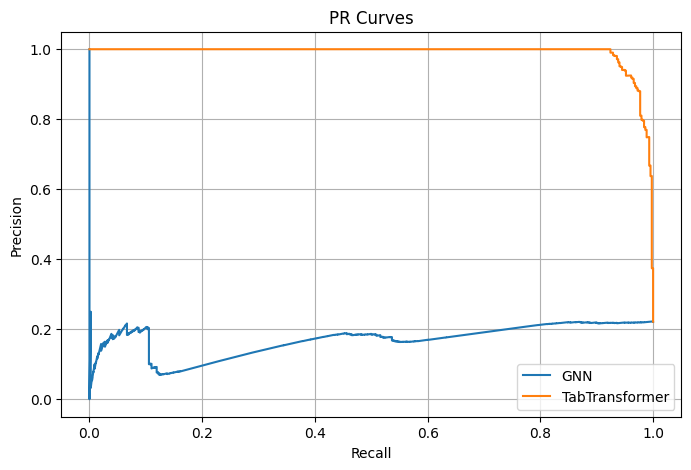

Done. Artifacts and models saved to ./artifacts


In [53]:
# 8) Compare & plots (basic)

try:
    import matplotlib.pyplot as plt
    from sklearn.metrics import precision_recall_curve

    # Ensure GNN model is in eval mode and compute GNN probabilities for the test node indices.
    # Note: `model` here is the GNN (NodeGNN) defined earlier; `x_nodes` and `edge_index` are full-graph tensors.
    model.eval()
    with torch.no_grad():
        # forward pass -> raw logits for all nodes, then sigmoid to get probabilities
        # finally index by test_idx to keep only the test-node probabilities
        gnn_probs = torch.sigmoid(model(x_nodes, edge_index)).cpu().numpy()[test_idx]

    # Compute precision-recall curve points for GNN using the true test labels from the combined y array.
    pr_g, rc_g, _ = precision_recall_curve(y[test_idx], gnn_probs)

    # Compute precision-recall curve points for the TabTransformer.
    # IMPORTANT: this uses `logits` and `ytrue` variables created previously in the TabTransformer cell.
    # `logits` here should contain the TabTransformer probabilities from that cell (after sigmoid).
    # If `logits` was overwritten, this call may be incorrect — ensure the TabTransformer evaluation
    # block ran before this cell and that `logits` contains the TabTransformer outputs.
    pr_t, rc_t, _ = precision_recall_curve(ytrue, logits)

    # Plot PR curves for both models for visual comparison
    plt.figure(figsize=(8,5))
    plt.plot(rc_g, pr_g, label='GNN')              # plot GNN recall vs precision
    plt.plot(rc_t, pr_t, label='TabTransformer')  # plot TabTransformer recall vs precision
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.title('PR Curves')
    plt.show()

except Exception as e:
    # If anything goes wrong (missing variables, plotting backend, etc.), print the error
    print('Plotting failed:', e)

# Final confirmation message indicating where artifacts were written
print('Done. Artifacts and models saved to', ARTIFACTS_DIR)


In [54]:
# ---- Recreate legacy X.npy and y.npy for backward compatibility ----

import os, numpy as np
ARTIFACTS_DIR = './artifacts'

# Load previously saved train, validation, and test feature arrays
X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
X_val   = np.load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
X_test  = np.load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))

# Load corresponding target label arrays
y_train = np.load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))

# Concatenate all splits vertically to reconstruct the complete dataset (features + labels)
# This is useful for compatibility with older code versions or visualizations that expect single X/y files.
X_all = np.vstack([X_train, X_val, X_test])
y_all = np.concatenate([y_train, y_val, y_test])

# Save the reconstructed arrays as X.npy and y.npy
# These files contain all rows (train + val + test) and are mainly for downstream legacy modules.
np.save(os.path.join(ARTIFACTS_DIR, "X.npy"), X_all)
np.save(os.path.join(ARTIFACTS_DIR, "y.npy"), y_all)

# Print confirmation message
print("✅ Created X.npy and y.npy for compatibility with downstream cells.")


✅ Created X.npy and y.npy for compatibility with downstream cells.


In [55]:
# ---- Add and run this: Train & evaluate LogisticRegression and SVM (save artifacts) ----

import os, joblib, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score, precision_recall_curve, auc, classification_report

# directory for reading/writing preprocessing artifacts and model outputs
ARTIFACTS_DIR = './artifacts'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Load previously saved train/val/test arrays produced by preprocessing step
X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
X_val   = np.load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
X_test  = np.load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))
y_train = np.load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))

# --- 1) Logistic Regression (Grid search over C) ---
print("Training LogisticRegression (GridSearchCV)...")
# Use 'saga' solver which supports large datasets and works with L2; class_weight='balanced' helps with class imbalance
lr = LogisticRegression(class_weight='balanced', solver='saga', max_iter=5000, random_state=42)
# grid over regularization strength C (smaller C => stronger regularization). Penalty L2 recommended for stability.
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}  # l1 is possible with saga but often slower/less stable
# GridSearchCV will fit multiple models with 5-fold CV, optimizing ROC-AUC. n_jobs=-1 uses all CPUs.
gs_lr = GridSearchCV(lr, param_grid_lr, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
gs_lr.fit(X_train, y_train)               # fit on training split (no leakage from val/test)
best_lr = gs_lr.best_estimator_           # best model found by CV
print("LogReg best params:", gs_lr.best_params_)

# Evaluation helper function that prints multiple metrics and returns probs,preds for saving
def print_eval(name, model, X_, y_):
    # If model supports predict_proba use probability of positive class; otherwise use decision_function
    probs = model.predict_proba(X_)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_)
    preds = (probs > 0.5).astype(int)    # threshold at 0.5 to produce class predictions
    auc_score = roc_auc_score(y_, probs) # ROC-AUC using continuous scores
    prec, rec, f1, _ = precision_recall_fscore_support(y_, preds, average='binary', zero_division=0)
    acc = accuracy_score(y_, preds)
    pr, rc, _ = precision_recall_curve(y_, probs)
    pr_auc = auc(rc, pr)                 # area under precision-recall curve
    # Print compact single-line summary plus classification report for deeper inspection
    print(f"{name} TEST auc: {auc_score:.6f} prec: {prec:.6f} rec: {rec:.6f} f1: {f1:.6f} acc: {acc:.6f} PR-AUC: {pr_auc:.6f}")
    print("Classification report:\n", classification_report(y_, preds))
    return probs, preds

# Evaluate best logistic regression on the test set and persist artifacts
lr_probs, lr_preds = print_eval("LogisticRegression", best_lr, X_test, y_test)
joblib.dump(best_lr, os.path.join(ARTIFACTS_DIR, "logreg_best.pkl"))   # save best LogisticRegression model
np.save(os.path.join(ARTIFACTS_DIR, "logreg_test_probs.npy"), lr_probs)
np.save(os.path.join(ARTIFACTS_DIR, "logreg_test_preds.npy"), lr_preds)
np.save(os.path.join(ARTIFACTS_DIR, "logreg_test_true.npy"), y_test)
print("Saved LogisticRegression artifacts.")

# --- 2) SVM (probabilistic SVC) with Randomized search (small search, may be slow) ---
# SVC(probability=True) performs Platt scaling internally to give probabilities (slower than raw SVM).
print("Training SVC (RandomizedSearchCV, may take time)...")
svc = SVC(class_weight='balanced', probability=True, random_state=42)

# Use scipy.stats distributions for randomized search sampling of continuous hyperparameters
from scipy.stats import uniform, randint
param_dist_svc = {
    'C': uniform(0.1, 100),           # sample C from 0.1 .. 100.1
    'gamma': uniform(1e-4, 0.1),     # sample gamma for RBF kernel from small positive range
    'kernel': ['rbf']                # RBF kernel only in this search
}
# RandomizedSearchCV will evaluate n_iter sampled parameter sets using 5-fold CV optimizing ROC-AUC
rs_svc = RandomizedSearchCV(svc, param_distributions=param_dist_svc, n_iter=20, scoring='roc_auc', cv=5, n_jobs=-1, random_state=42, verbose=1)
rs_svc.fit(X_train, y_train)
best_svc = rs_svc.best_estimator_
print("SVC best params:", rs_svc.best_params_)

# Evaluate and save SVM artifacts (probabilities, preds, true)
svc_probs, svc_preds = print_eval("SVM", best_svc, X_test, y_test)
joblib.dump(best_svc, os.path.join(ARTIFACTS_DIR, "svm_best.pkl"))     # persist best SVM model
np.save(os.path.join(ARTIFACTS_DIR, "svm_test_probs.npy"), svc_probs)
np.save(os.path.join(ARTIFACTS_DIR, "svm_test_preds.npy"), svc_preds)
np.save(os.path.join(ARTIFACTS_DIR, "svm_test_true.npy"), y_test)
print("Saved SVM artifacts.")

# Done
print("LogReg + SVM training/evaluation done.")


Training LogisticRegression (GridSearchCV)...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
LogReg best params: {'C': 100, 'penalty': 'l2'}
LogisticRegression TEST auc: 0.908151 prec: 0.750000 rec: 0.853211 f1: 0.798283 acc: 0.904520 PR-AUC: 0.803992
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      1533
           1       0.75      0.85      0.80       436

    accuracy                           0.90      1969
   macro avg       0.85      0.89      0.87      1969
weighted avg       0.91      0.90      0.91      1969

Saved LogisticRegression artifacts.
Training SVC (RandomizedSearchCV, may take time)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVC best params: {'C': np.float64(5.908361216819946), 'gamma': np.float64(0.08671761457749352), 'kernel': 'rbf'}
SVM TEST auc: 0.992916 prec: 0.997462 rec: 0.901376 f1: 0.946988 acc: 0.977654 PR-AUC: 0.980561
Classification report:
  

Models found for comparison: ['GNN', 'TabTransformer', 'LightGBM', 'LogReg', 'SVM']
            model   ROC-AUC    PR-AUC  precision    recall        f1       acc
0        LightGBM  0.999527  0.998562   0.995294  0.970183  0.982578  0.992382
1  TabTransformer  0.995950  0.990119   1.000000  0.922018  0.959427  0.982732
2             SVM  0.992916  0.980446   0.997462  0.901376  0.946988  0.977654
3          LogReg  0.908151  0.804951   0.750000  0.853211  0.798283  0.904520
4             GNN  0.515026  0.236323   0.231895  0.690367  0.347174  0.425089


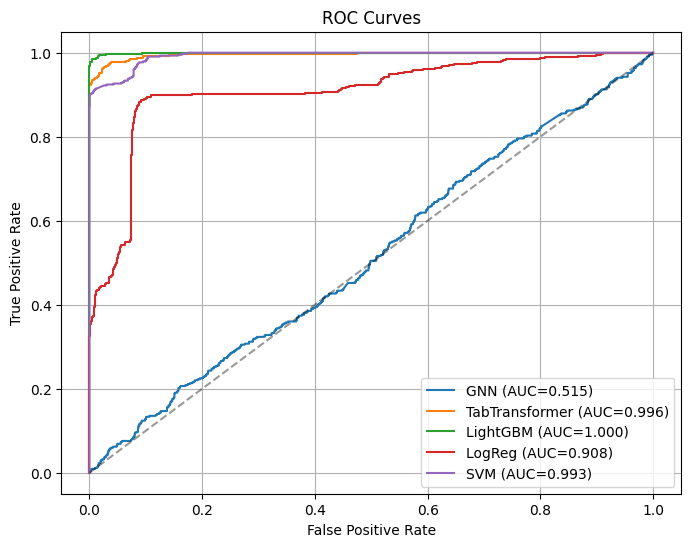

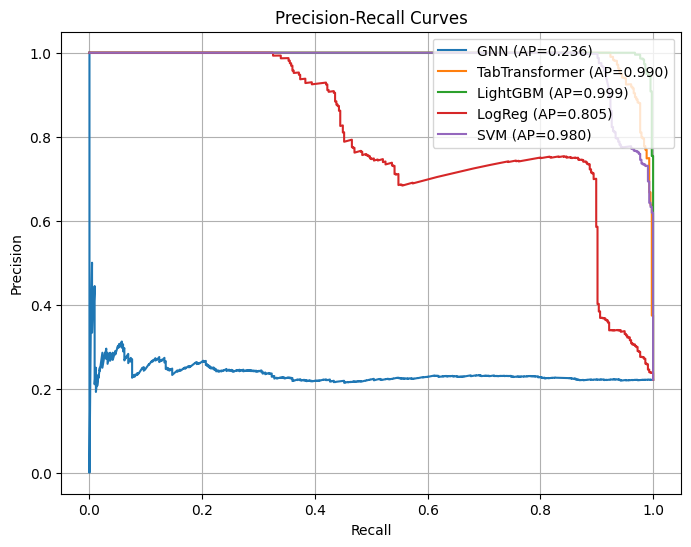

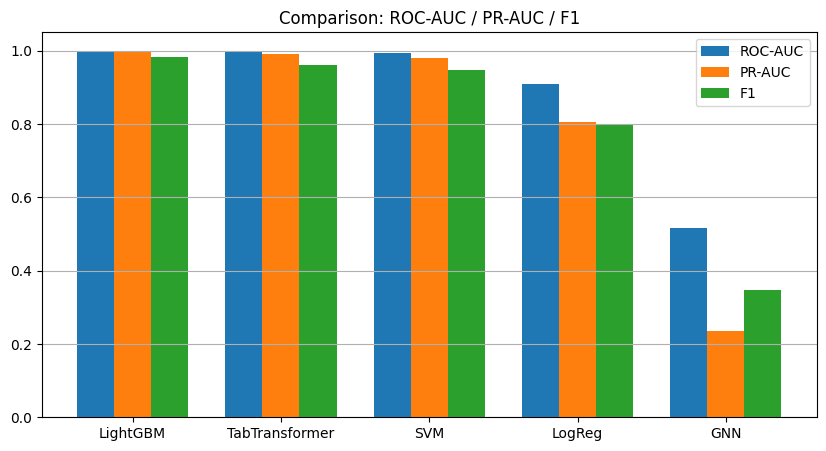

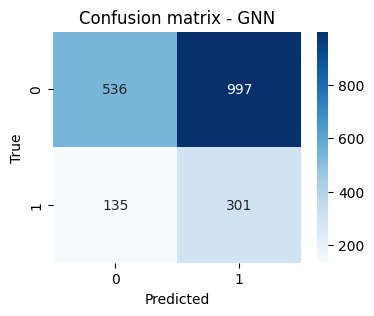

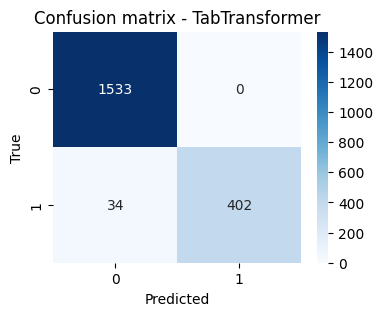

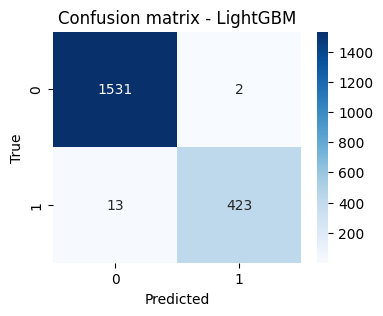

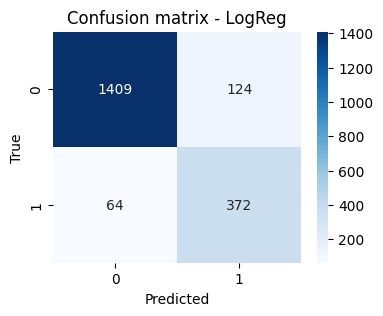

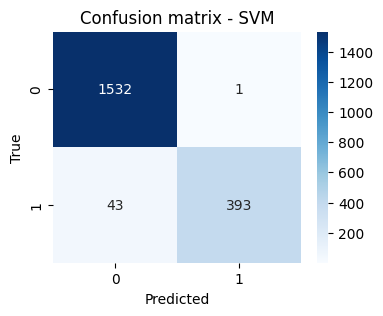

Saved models_comparison_metrics.csv in artifacts.


In [56]:
# ---- Comparison & Plots for all available models ----

# standard libs + plotting + pandas for metrics table
import os, numpy as np, matplotlib.pyplot as plt, pandas as pd
# scikit-learn metrics used throughout
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score, confusion_matrix, precision_recall_fscore_support

# directory holding saved model outputs (probs/preds/true)
ARTIFACTS_DIR = './artifacts'

# mapping of human-friendly model names -> filename that stores test probabilities
model_keys = {
    'GNN': 'gnn_test_probs.npy',
    'TabTransformer': 'tab_test_probs.npy',
    'LightGBM': 'lgb_test_probs.npy',
    'LogReg': 'logreg_test_probs.npy',
    'SVM': 'svm_test_probs.npy'
}

# -------------------------
# Load ground-truth test labels
# Prefer model-specific *_true.npy files if present (they may reflect the exact test slice used for that model).
# Otherwise fallback to the common y_test.npy saved during preprocessing.
y_true = None
for fname in ["gnn_test_true.npy","tab_test_true.npy","lgb_test_true.npy","logreg_test_true.npy","svm_test_true.npy"]:
    fp = os.path.join(ARTIFACTS_DIR, fname)
    if os.path.exists(fp):
        # allow_pickle=True in case these were saved as object arrays / strings (robust loading)
        y_true = np.load(fp, allow_pickle=True)
        break
if y_true is None:
    # fallback: load canonical test labels
    y_true = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))

# -------------------------
# Gather probabilities and preds for each model that has a saved file.
# For models missing explicit preds file, derive preds with threshold 0.5.
results = {}
for name, f in model_keys.items():
    ppath = os.path.join(ARTIFACTS_DIR, f)
    if os.path.exists(ppath):
        # load probability array (allow_pickle for safety)
        probs = np.load(ppath, allow_pickle=True)
        # try to locate corresponding preds file by convention
        preds_path = os.path.join(ARTIFACTS_DIR, f.replace('_probs', '_preds'))
        preds = None
        if os.path.exists(preds_path):
            preds = np.load(preds_path, allow_pickle=True)
        else:
            # fallback threshold at 0.5 -> binary predictions
            preds = (probs > 0.5).astype(int)
        results[name] = {'probs': probs, 'preds': preds}
# print which models were found for comparison
print("Models found for comparison:", list(results.keys()))

# -------------------------
# Compute summary metrics for each available model and collect into a DataFrame.
rows = []
for name,vals in results.items():
    probs = vals['probs']
    preds = vals['preds']
    # ROC AUC (uses continuous scores)
    auc_score = roc_auc_score(y_true, probs)
    # Average precision (area under PR curve), often reported as AP
    pr_auc = average_precision_score(y_true, probs)
    # Precision/recall/f1 at threshold 0.5
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, preds, average='binary', zero_division=0)
    # simple accuracy
    acc = (preds==y_true).mean()
    rows.append({'model':name, 'ROC-AUC':auc_score, 'PR-AUC':pr_auc, 'precision':prec, 'recall':rec, 'f1':f1, 'acc':acc})
# Build a sorted DataFrame for easy inspection (sorted by ROC-AUC desc)
df_metrics = pd.DataFrame(rows).sort_values('ROC-AUC', ascending=False).reset_index(drop=True)
print(df_metrics)

# -------------------------
# Plot 1: ROC curves for all models found
plt.figure(figsize=(8,6))
for name, vals in results.items():
    # compute ROC curve points and AUC
    fpr, tpr, _ = roc_curve(y_true, vals['probs'])
    roc_auc = auc(fpr, tpr)
    # add to plot with AUC in legend
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
# diagonal baseline
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# -------------------------
# Plot 2: Precision-Recall curves (recall on x-axis, precision on y-axis)
plt.figure(figsize=(8,6))
for name, vals in results.items():
    pr, rc, _ = precision_recall_curve(y_true, vals['probs'])
    ap = average_precision_score(y_true, vals['probs'])
    plt.plot(rc, pr, label=f"{name} (AP={ap:.3f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# -------------------------
# Plot 3: Bar chart comparing ROC-AUC, PR-AUC and F1 for each model
plt.figure(figsize=(10,5))
x = np.arange(len(df_metrics))
width = 0.25
# three side-by-side bars per model: ROC-AUC, PR-AUC, F1
plt.bar(x - width, df_metrics['ROC-AUC'], width, label='ROC-AUC')
plt.bar(x, df_metrics['PR-AUC'], width, label='PR-AUC')
plt.bar(x + width, df_metrics['f1'], width, label='F1')
plt.xticks(x, df_metrics['model'])
plt.ylim(0,1.05)
plt.title('Comparison: ROC-AUC / PR-AUC / F1')
plt.legend()
plt.grid(axis='y')
plt.show()

# -------------------------
# Plot 4: Confusion matrices for each model (visualized via seaborn heatmap)
import seaborn as sns
for name, vals in results.items():
    cm = confusion_matrix(y_true, vals['preds'])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# -------------------------
# Save the metrics summary as a CSV inside artifacts for later reference / inclusion in reports
df_metrics.to_csv(os.path.join(ARTIFACTS_DIR, "models_comparison_metrics.csv"), index=False)
print("Saved models_comparison_metrics.csv in artifacts.")
# ---- end compare cell ----


In [57]:
# load tuned model you just saved
import joblib
best = joblib.load(os.path.join(ARTIFACTS_DIR, "lgb_best.pkl"))
feat_names = np.load(os.path.join(ARTIFACTS_DIR, "feature_names.npy")) if os.path.exists(os.path.join(ARTIFACTS_DIR, "feature_names.npy")) else None

importances = best.feature_importances_
order = np.argsort(importances)[::-1][:30]
print("Top 30 feature importances (index, score):")
for i in order:
    name = feat_names[i] if feat_names is not None else f"f{i}"
    print(name, importances[i])


Top 30 feature importances (index, score):
f2 1928
f5 1114
f16 1009
f1 973
f15 867
f46 845
f9 826
f0 813
f10 716
f8 715
f13 667
f14 649
f7 620
f4 573
f12 491
f45 487
f3 454
f17 414
f11 408
f18 398
f23 338
f6 320
f24 268
f25 255
f20 249
f19 242
f22 232
f21 214
f26 194
f28 178


In [58]:
import os, pickle, numpy as np, pandas as pd
ARTIFACTS_DIR = './artifacts'

# load preproc meta
with open(os.path.join(ARTIFACTS_DIR, "preproc_train_encoders.pkl"), "rb") as f:
    meta = pickle.load(f)

numeric_cols = meta['numeric_cols']
categorical_cols = meta['categorical_cols']
feature_cols = meta.get('feature_cols', numeric_cols + categorical_cols)

print("Total features (feature_cols length):", len(feature_cols))
print("Numeric cols (count):", len(numeric_cols))
print("Categorical cols (count):", len(categorical_cols))
print("\nFirst 30 features (in order expected):")
print(feature_cols[:30])

# load X_train to inspect shape and some rows
X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
print("\nX_train shape:", X_train.shape)
# Make a small DataFrame to display first 5 rows with column names
df_Xtrain = pd.DataFrame(X_train[:5, :], columns=feature_cols)
display(df_Xtrain)


Total features (feature_cols length): 47
Numeric cols (count): 31
Categorical cols (count): 16

First 30 features (in order expected):
['Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr']

X_train shape: (6691, 47)


,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,-0.244102,-0.284347,0.016588,-0.152571,-0.023832,-0.098593,-0.101792,-0.133156,-0.043788,-0.032947,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,90.0
1,-0.182187,-0.222369,0.631482,-0.068774,-0.055729,-0.098593,-0.094003,-0.133010,-0.043964,-0.033322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,170.0
2,-0.244102,0.737654,-0.068964,-0.152571,-0.165824,-0.088642,-0.101792,-0.133156,-0.040741,-0.030628,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,235.0
3,-0.244102,-0.352443,-0.679549,-0.151262,-0.173027,-0.101910,-0.097898,-0.118499,-0.043661,-0.031947,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0
4,-0.243101,-0.352443,-0.679775,-0.149952,-0.173027,-0.101910,-0.094003,0.162915,-0.037571,-0.004430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0


In [59]:
leaks = [c for c in ['Unnamed: 0', 'Index'] if c in feature_cols]
print("Leaky columns present in feature_cols:", leaks)

# also check original df if available
if os.path.exists('/mnt/data/ethereum_raw.csv'):
    df = pd.read_csv('/mnt/data/ethereum_raw.csv', low_memory=False)
    print("Original df columns containing 'Unnamed' or 'Index':", [c for c in df.columns if 'Unnamed' in c or 'Index' in c])


Leaky columns present in feature_cols: []


In [60]:
# Confirm dropped leak and consistent columns
print('Unnamed: 0' in meta['feature_cols'])  # should print False
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


False
Shapes: (6691, 47) (1181, 47) (1969, 47)


In [61]:
# Check address overlap (just in case)
import numpy as np, os
a_tr = np.load(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), allow_pickle=True)
a_te = np.load(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), allow_pickle=True)
print("Train/Test address overlap:", len(set(a_tr).intersection(set(a_te))))


Train/Test address overlap: 9


In [62]:
import numpy as np, os
for f in ['tab_test_probs.npy','tab_test_preds.npy','tab_test_true.npy','gnn_test_probs.npy','gnn_test_preds.npy','gnn_test_true.npy']:
    a = np.load(os.path.join('./artifacts', f), allow_pickle=True)
    print(f, a.shape, a.dtype, np.unique(a)[:5])


tab_test_probs.npy (1969,) float32 [0.0001656  0.00016682 0.00016682 0.00016682 0.00016682]
tab_test_preds.npy (1969,) int64 [0 1]
tab_test_true.npy (1969,) int64 [0 1]
gnn_test_probs.npy (1969,) float32 [2.0514946e-05 1.5298977e-04 8.1437444e-03 2.9943036e-02 3.7042949e-02]
gnn_test_preds.npy (1969,) int64 [0 1]
gnn_test_true.npy (1969,) int64 [0 1]
